# getting started

In [16]:
#reading in data
# %load_ext autoreload
# %autoreload 2
import IPython
print(IPython.get_ipython().config)
import os
os.getcwd()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster
from collections import defaultdict
from scipy.stats import spearmanr, pearsonr
import requests
import json
import sys
import os
import pickle

project_root = os.path.abspath(os.path.join(os.getcwd(), '../../../'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

#functions written by AK:
from Abdullah_kuziez.preprocessing.pre_processing_py_fxns.filtering_functions import *
from Abdullah_kuziez.preprocessing.pre_processing_py_fxns.graphing_fxns import *
from Abdullah_kuziez.preprocessing.pre_processing_py_fxns.making_cellbox_files import *
from Abdullah_kuziez.preprocessing.pre_processing_py_fxns.Initial_structuring import *

{'IPKernelApp': {'connection_file': '/run/user/210498/jupyter/runtime/kernel-v3be4b4875eb70caac42ed045173941ec1c014a589.json'}, 'Completer': {'use_jedi': False}}


In [17]:
intermediate_dir_48hr = Path("intermediate_files_TNBC/48hr")
data_48hr=load_data(intermediate_dir_48hr, "48hr")
intermediate_dir_6hr = Path("intermediate_files_TNBC/6hr")
data_6hr=load_data(intermediate_dir_6hr, "6hr")
intermediate_dir_24hr = Path("intermediate_files_TNBC/24hr")
data_24hr=load_data(intermediate_dir_24hr, "24hr")

#splitting the data into targeted and non_targeted proteins:
all_targeted_prots=[item for sublist in data_48hr['drug_pert_id_targets_dict'].values() for item in sublist]

targeted_prots_raw_6hr,targeted_prots_raw_24hr,targeted_prots_raw_48hr={},{},{}
non_targeted_prots_raw_6hr,non_targeted_prots_raw_24hr,non_targeted_prots_raw_48hr={},{},{}
cell_lines=data_48hr['cell_lines']
for cell in cell_lines:
    meta_cols_48hr=data_48hr['data_by_cell_line_raw'][cell].columns[data_48hr['data_by_cell_line_raw'][cell].columns.str.contains('meta_')]
    meta_cols_6hr=data_6hr['data_by_cell_line_raw'][cell].columns[data_6hr['data_by_cell_line_raw'][cell].columns.str.contains('meta_')]
    meta_cols_24hr=data_24hr['data_by_cell_line_raw'][cell].columns[data_24hr['data_by_cell_line_raw'][cell].columns.str.contains('meta_')]

    intersection_48hr=list(set(all_targeted_prots).intersection(set(data_48hr['data_by_cell_line_raw'][cell].columns)))
    intersection_6hr=list(set(all_targeted_prots).intersection(set(data_6hr['data_by_cell_line_raw'][cell].columns)))
    intersection_24hr=list(set(all_targeted_prots).intersection(set(data_24hr['data_by_cell_line_raw'][cell].columns)))


    targeted_prots_raw_48hr[cell] = data_48hr['data_by_cell_line_raw'][cell][list(intersection_48hr) + list(meta_cols_48hr)]
    targeted_prots_raw_6hr[cell] = data_6hr['data_by_cell_line_raw'][cell][list(intersection_6hr) + list(meta_cols_6hr)]
    targeted_prots_raw_24hr[cell] = data_24hr['data_by_cell_line_raw'][cell][list(intersection_24hr) + list(meta_cols_24hr)]
    
    non_targeted_prots_raw_48hr[cell]=data_48hr['data_by_cell_line_raw'][cell].drop(columns=intersection_48hr)
    non_targeted_prots_raw_6hr[cell]=data_6hr['data_by_cell_line_raw'][cell].drop(columns=intersection_6hr)
    non_targeted_prots_raw_24hr[cell]=data_24hr['data_by_cell_line_raw'][cell].drop(columns=intersection_24hr)

In [18]:
#pipeline setup for all timepoints
saved_filter_dir=r'filtering_results'
pipeline_steps_tgt=[['filter_proteins_with_control', '_'],
                ['log2_transform_by_control', '_'],
                ['filter_incomplete_proteins', '.95'],
                ['filter_incomplete_experiments', '.95'],
                ['fill_na_with_mean', '_'],
                # ['filter_keep_low_cv', '.8'],
                # ['remove_outlier_proteins', '10'],
                ['filter_by_mutual_information', '.001','meta_Inhi_5'],
                # ['iterative_signal_filtering', '2.5'],
                # ['spearman_corr_filtering', '0.2','meta_Inhi_5'],
                # ['pearson_corr_filtering', '0.2','meta_Inhi_5']
                ]

pipeline_steps_nontgt=[['filter_proteins_with_control', '_'],
                ['log2_transform_by_control', '_'],
                ['filter_incomplete_proteins', '.8'],
                ['filter_incomplete_experiments', '.8'],
                ['fill_na_with_mean', '_'],
                # ['filter_keep_low_cv', '.8'],
                # ['remove_outlier_proteins', '10'],
                ['filter_by_mutual_information', '.001','meta_Inhi_5'],
                ['iterative_signal_filtering', '3'],
                ['spearman_corr_filtering', '0.2','meta_Inhi_5'],
                ['pearson_corr_filtering', '0.2','meta_Inhi_5'],
                ['noise injected', '_']
                ]
config={'print_flag':False,'graph_flag':False,'graph_type':'hist','filter_flag':True,'verbose':True}
#//////////LOO regression////////////////////////////
from sklearn.linear_model import ElasticNetCV

elasticnet_model= ElasticNetCV(
    alphas=[0.001, 0.01, 0.1, 1.0, 10.0],           # Alpha values to scan
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],            # L1 ratio values to scan
    cv=5,                                            # 5-fold CV for parameter selection
    random_state=42,
    max_iter=5000
)

targeted proteins 6hr
applying filter 1 of 6: ['filter_proteins_with_control', '_']
filtering proteins with control values
applying filter 2 of 6: ['log2_transform_by_control', '_']
log2 transforming by control
applying filter 3 of 6: ['filter_incomplete_proteins', '.95']
filtering incomplete proteins
[HS578T] 60 cols -> 36 prots
[HCC70] 51 cols -> 28 prots
[BT549] 55 cols -> 39 prots
[MDA-MB-453] 29 cols -> 19 prots
[MCF7] 41 cols -> 28 prots
[DU4475] 42 cols -> 20 prots
applying filter 4 of 6: ['filter_incomplete_experiments', '.95']
filtering incomplete experiments
[HS578T] 39 experiments -> 39 experiments, 36 prots
[HCC70] 46 experiments -> 46 experiments, 28 prots
[BT549] 59 experiments -> 59 experiments, 39 prots
[MDA-MB-453] 57 experiments -> 57 experiments, 19 prots
[MCF7] 45 experiments -> 44 experiments, 28 prots
[DU4475] 57 experiments -> 56 experiments, 20 prots
applying filter 5 of 6: ['fill_na_with_mean', '_']
filling na with mean
applying filter 6 of 6: ['filter_by_mutua

applying filter 6 of 10: ['filter_by_mutual_information', '.001', 'meta_Inhi_5']
filtering by mutual information
applying filter 7 of 10: ['iterative_signal_filtering', '3']
filtering using iterative SNR filtering
applying filter 8 of 10: ['spearman_corr_filtering', '0.2', 'meta_Inhi_5']
filtering by spearman correlation
applying filter 9 of 10: ['pearson_corr_filtering', '0.2', 'meta_Inhi_5']
filtering by pearson correlation
applying filter 10 of 10: ['noise injected', '_']
filter ['noise injected', '_'] not found
////////////Hash:   b5d951   ///////////////////////////
+------------------------------------------+----------+---------+---------+--------------+--------+----------+
|                                          |   HS578T |   HCC70 |   BT549 |   MDA-MB-453 |   MCF7 |   DU4475 |
+==========================================+==========+=========+=========+==============+========+==========+
| raw_data                                 |     5417 |    5417 |    5417 |         5417 

'b5d951'

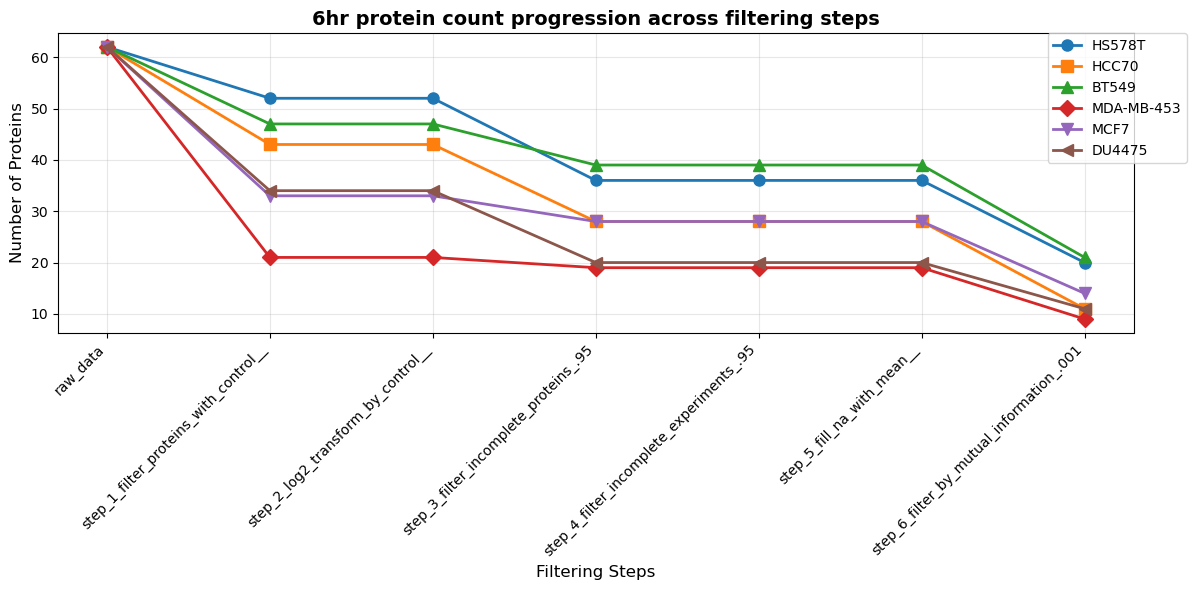

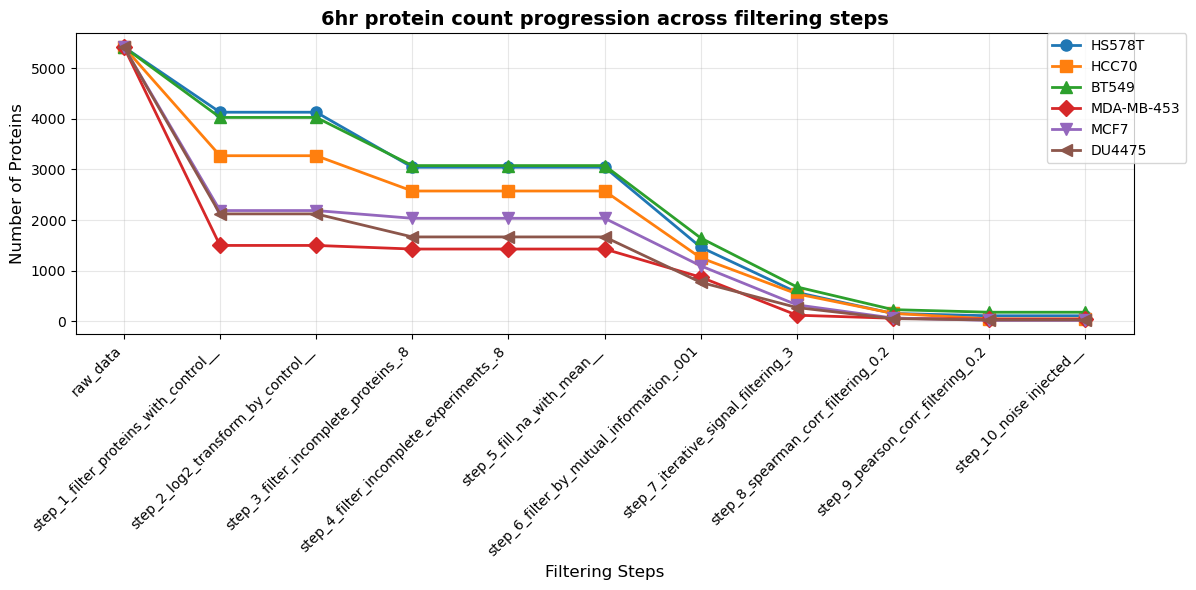

In [19]:
#6hr pipeline
print('targeted proteins 6hr')
six_hr_tgt_pipeline=filtering_pipeline(targeted_prots_raw_6hr,data_6hr['cell_lines'],data_6hr['control_data_by_cell_line'],'6hr',data_6hr['control_data_by_cell_line_coeffvar'],**config)
hd_six_tgt=six_hr_tgt_pipeline.run_pipeline(pipeline_steps_tgt,save_dir=saved_filter_dir,tgt='tgt')
sum_six_tgt=six_hr_tgt_pipeline.summary_of_pipeline()
six_hr_tgt_pipeline.save_pipeline(saved_filter_dir,tgt='tgt')

six_hr_non_tgt_pipeline=filtering_pipeline(non_targeted_prots_raw_6hr,data_6hr['cell_lines'],data_6hr['control_data_by_cell_line'],'6hr',data_6hr['control_data_by_cell_line_coeffvar'],**config)
hd_six_non_tgt=six_hr_non_tgt_pipeline.run_pipeline(pipeline_steps_nontgt,save_dir=saved_filter_dir,tgt='nontgt')
sum_six_non_tgt=six_hr_non_tgt_pipeline.summary_of_pipeline()
six_hr_non_tgt_pipeline.save_pipeline(saved_filter_dir,tgt='nontgt')
#inject noise after all the filtering happens

# six_hr_non_tgt_pipeline.noise_stability_test(mean_array=[0,1,1,1,1,1,1,1,1,1],sigma_array=[0,.001,.005,.01,.05,.1,.2,.4,.8,1])
# noisy_data=six_hr_non_tgt_pipeline.inject_noise(mean_mult=0,sigma_mult=0)

# _=six_hr_non_tgt_pipeline.run_loo_regression(ycol='meta_Inhi_5',model=elasticnet_model)

# plot_protein_correlation_heatmaps(six_hr_tgt_pipeline.final_filtered_data,cell_lines)
# plot_protein_correlation_heatmaps(six_hr_non_tgt_pipeline.final_filtered_data,cell_lines)

targeted proteins 24hr
applying filter 1 of 6: ['filter_proteins_with_control', '_']
filtering proteins with control values
applying filter 2 of 6: ['log2_transform_by_control', '_']
log2 transforming by control
applying filter 3 of 6: ['filter_incomplete_proteins', '.95']
filtering incomplete proteins
[HS578T] 60 cols -> 35 prots
[HCC70] 51 cols -> 28 prots
[BT549] 55 cols -> 38 prots
[MDA-MB-453] 29 cols -> 20 prots
[MCF7] 41 cols -> 28 prots
[DU4475] 42 cols -> 25 prots
applying filter 4 of 6: ['filter_incomplete_experiments', '.95']
filtering incomplete experiments
[HS578T] 39 experiments -> 39 experiments, 35 prots
[HCC70] 46 experiments -> 45 experiments, 28 prots
[BT549] 59 experiments -> 59 experiments, 38 prots
[MDA-MB-453] 57 experiments -> 57 experiments, 20 prots
[MCF7] 45 experiments -> 45 experiments, 28 prots
[DU4475] 57 experiments -> 56 experiments, 25 prots
applying filter 5 of 6: ['fill_na_with_mean', '_']
filling na with mean
applying filter 6 of 6: ['filter_by_mutu

'78b45b'

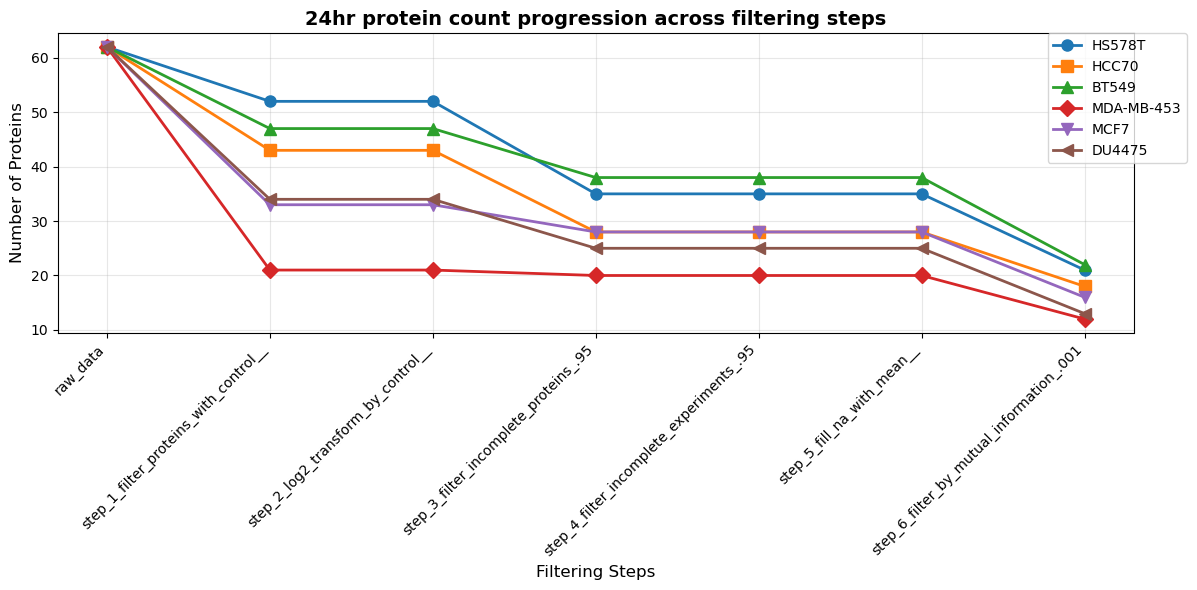

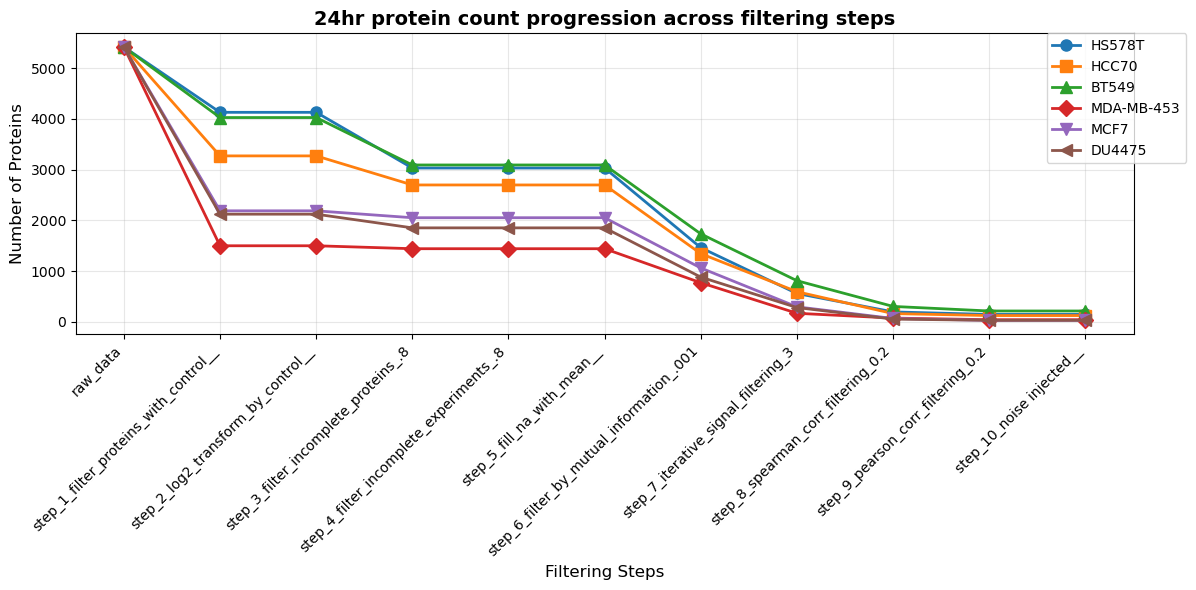

In [20]:
#24hr pipeline:
print('targeted proteins 24hr')
twenty_four_hr_tgt_pipeline=filtering_pipeline(targeted_prots_raw_24hr,data_24hr['cell_lines'],data_24hr['control_data_by_cell_line'],'24hr',data_24hr['control_data_by_cell_line_coeffvar'],**config)
hd_twentyfour_tgt=twenty_four_hr_tgt_pipeline.run_pipeline(pipeline_steps_tgt,save_dir=saved_filter_dir,tgt='tgt')
sum_twentyfour_tgt=twenty_four_hr_tgt_pipeline.summary_of_pipeline()
twenty_four_hr_tgt_pipeline.save_pipeline(saved_filter_dir,tgt='tgt')

print('non-targeted proteins 24hr')
twenty_four_hr_non_tgt_pipeline=filtering_pipeline(non_targeted_prots_raw_24hr,data_24hr['cell_lines'],data_24hr['control_data_by_cell_line'],'24hr',data_24hr['control_data_by_cell_line_coeffvar'],**config)
hd_twentyfour_non_tgt=twenty_four_hr_non_tgt_pipeline.run_pipeline(pipeline_steps_nontgt,save_dir=saved_filter_dir,tgt='nontgt')
sum_twentyfour_non_tgt=twenty_four_hr_non_tgt_pipeline.summary_of_pipeline()
twenty_four_hr_non_tgt_pipeline.save_pipeline(saved_filter_dir,tgt='nontgt')
# _=twenty_four_hr_non_tgt_pipeline.run_loo_regression(ycol='meta_Inhi_5',model=elasticnet_model)

# plot_protein_correlation_heatmaps(twenty_four_hr_tgt_pipeline.final_filtered_data,cell_lines)
# plot_protein_correlation_heatmaps(twenty_four_hr_non_tgt_pipeline.final_filtered_data,cell_lines)

targeted proteins 48hr
applying filter 1 of 6: ['filter_proteins_with_control', '_']
filtering proteins with control values
applying filter 2 of 6: ['log2_transform_by_control', '_']
log2 transforming by control
applying filter 3 of 6: ['filter_incomplete_proteins', '.95']
filtering incomplete proteins
[HS578T] 60 cols -> 31 prots
[HCC70] 51 cols -> 27 prots
[BT549] 55 cols -> 37 prots
[MDA-MB-453] 29 cols -> 20 prots
[MCF7] 41 cols -> 27 prots
[DU4475] 42 cols -> 26 prots
applying filter 4 of 6: ['filter_incomplete_experiments', '.95']
filtering incomplete experiments
[HS578T] 39 experiments -> 37 experiments, 31 prots
[HCC70] 46 experiments -> 42 experiments, 27 prots
[BT549] 59 experiments -> 57 experiments, 37 prots
[MDA-MB-453] 57 experiments -> 57 experiments, 20 prots
[MCF7] 45 experiments -> 43 experiments, 27 prots
[DU4475] 57 experiments -> 55 experiments, 26 prots
applying filter 5 of 6: ['fill_na_with_mean', '_']
filling na with mean
applying filter 6 of 6: ['filter_by_mutu

'cfc4b0'

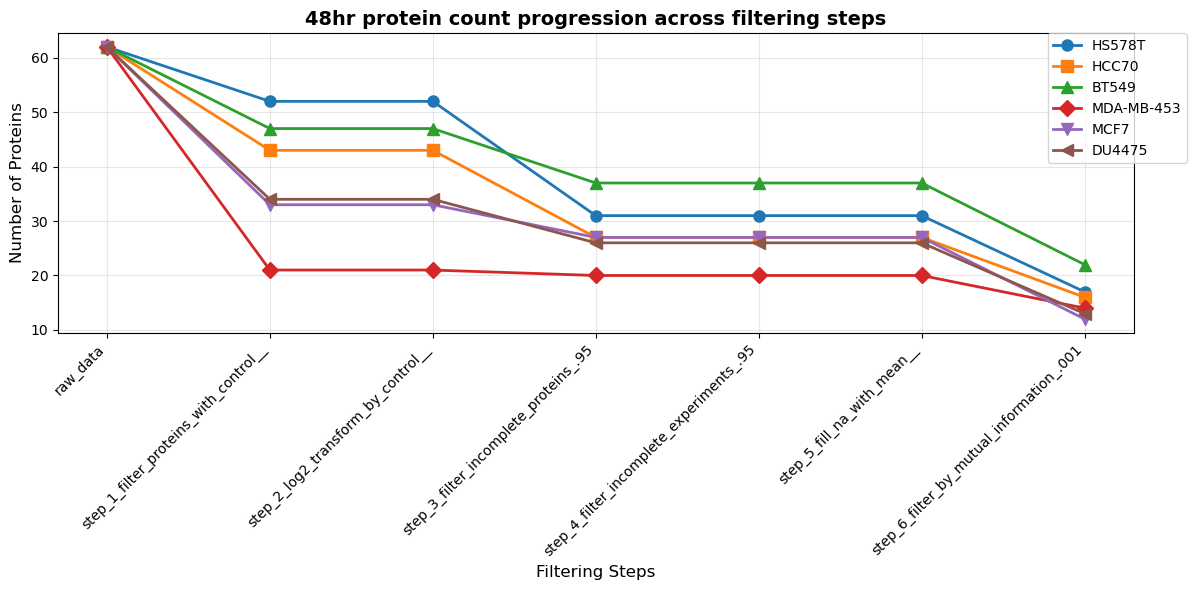

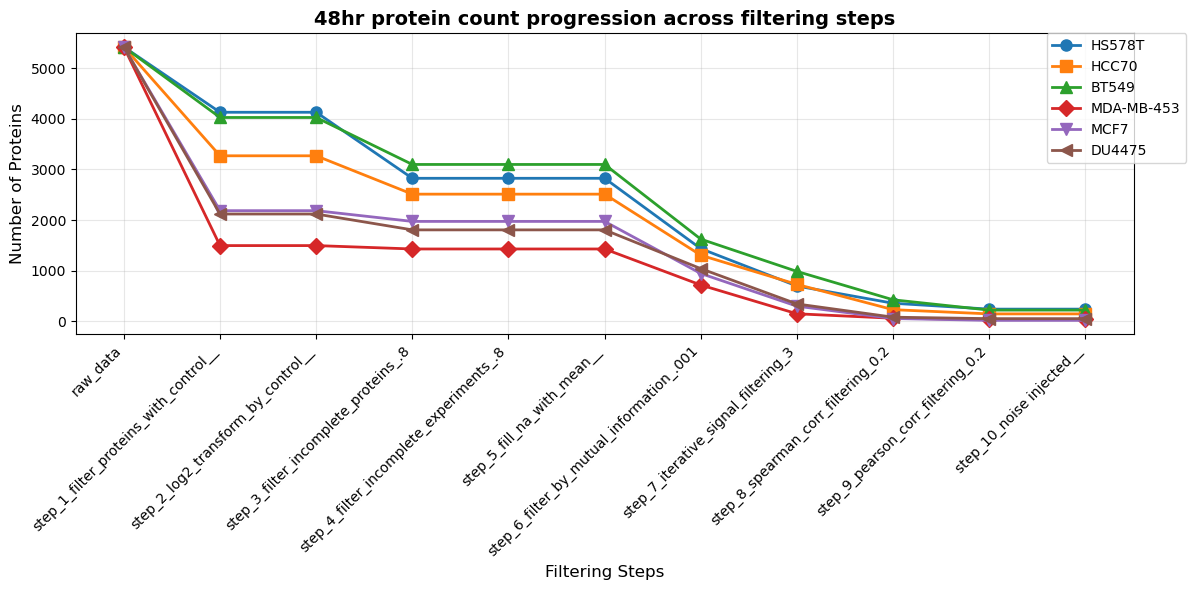

In [21]:
#48hr pipeline:
print('targeted proteins 48hr')
forty_eight_hr_tgt_pipeline=filtering_pipeline(targeted_prots_raw_48hr,data_48hr['cell_lines'],data_48hr['control_data_by_cell_line'],'48hr',data_48hr['control_data_by_cell_line_coeffvar'],**config)
hd_fortyeight_tgt=forty_eight_hr_tgt_pipeline.run_pipeline(pipeline_steps_tgt,save_dir=saved_filter_dir,tgt='tgt')
sum_fortyeight_tgt=forty_eight_hr_tgt_pipeline.summary_of_pipeline()
forty_eight_hr_tgt_pipeline.save_pipeline(saved_filter_dir,tgt='tgt')

print('non-targeted proteins 48hr')
forty_eight_hr_non_tgt_pipeline=filtering_pipeline(non_targeted_prots_raw_48hr,data_48hr['cell_lines'],data_48hr['control_data_by_cell_line'],'48hr',data_48hr['control_data_by_cell_line_coeffvar'],**config)
hd_fortyeight_non_tgt=forty_eight_hr_non_tgt_pipeline.run_pipeline(pipeline_steps_nontgt,save_dir=saved_filter_dir,tgt='nontgt')
sum_fortyeight_non_tgt=forty_eight_hr_non_tgt_pipeline.summary_of_pipeline()
forty_eight_hr_non_tgt_pipeline.save_pipeline(saved_filter_dir,tgt='nontgt')
# _=forty_eight_hr_non_tgt_pipeline.run_loo_regression(ycol='meta_Inhi_5',model=elasticnet_model)
# plot_protein_correlation_heatmaps(forty_eight_hr_tgt_pipeline.final_filtered_data,cell_lines)
# plot_protein_correlation_heatmaps(forty_eight_hr_non_tgt_pipeline.final_filtered_data,cell_lines)


In [22]:
#making combined dicts and ablation studying to get the most important so that I can have 100 nodes:
#ablation studying:
#TODO reimpleent the ablation study


#make the combined dictionaries,
combined_6hr_dict,combined_24hr_dict,combined_48hr_dict={},{},{}
combined_6hr_dict_log,combined_24hr_dict_log,combined_48hr_dict_log={},{},{}
for cell in six_hr_non_tgt_pipeline.final_filtered_data.keys():
    combined_6hr_dict[cell]=pd.concat([six_hr_tgt_pipeline.final_filtered_data[cell],six_hr_non_tgt_pipeline.final_filtered_data[cell]],axis=1)
    combined_24hr_dict[cell]=pd.concat([twenty_four_hr_tgt_pipeline.final_filtered_data[cell],twenty_four_hr_non_tgt_pipeline.final_filtered_data[cell]],axis=1)
    combined_48hr_dict[cell]=pd.concat([forty_eight_hr_tgt_pipeline.final_filtered_data[cell],forty_eight_hr_non_tgt_pipeline.final_filtered_data[cell]],axis=1)

    combined_6hr_dict_log[cell] = pd.concat([
        six_hr_tgt_pipeline.outputs_from_steps['step_2_log2_transform_by_control__']['filtered_data'][cell],
        six_hr_non_tgt_pipeline.outputs_from_steps['step_2_log2_transform_by_control__']['filtered_data'][cell]
    ], axis=1)
    combined_6hr_dict_log[cell] = combined_6hr_dict_log[cell].loc[:, ~combined_6hr_dict_log[cell].columns.duplicated()]

    combined_24hr_dict_log[cell] = pd.concat([
        twenty_four_hr_tgt_pipeline.outputs_from_steps['step_2_log2_transform_by_control__']['filtered_data'][cell],
        twenty_four_hr_non_tgt_pipeline.outputs_from_steps['step_2_log2_transform_by_control__']['filtered_data'][cell]
    ], axis=1)
    combined_24hr_dict_log[cell] = combined_24hr_dict_log[cell].loc[:, ~combined_24hr_dict_log[cell].columns.duplicated()]

    combined_48hr_dict_log[cell] = pd.concat([
        forty_eight_hr_tgt_pipeline.outputs_from_steps['step_2_log2_transform_by_control__']['filtered_data'][cell],
        forty_eight_hr_non_tgt_pipeline.outputs_from_steps['step_2_log2_transform_by_control__']['filtered_data'][cell]
    ], axis=1)
    combined_48hr_dict_log[cell] = combined_48hr_dict_log[cell].loc[:, ~combined_48hr_dict_log[cell].columns.duplicated()]

#now make cellbox files for each of the timepoints:
#cellbox files look like:
#node_Index, a list of the names of each of the nodes
#pert.csv has all the experiments as rows, and proteins/nodes as columns; expressions zeroed out and the activities are tanh transformed;
#expr.csv has all the experiments as rows, and proteins/nodes as columns; expressions are log2 transformed and activites are tanh transformed


In [23]:
selected_cell_line=['HS578T']
drug_pert_id_targets_dict=data_48hr['drug_pert_id_targets_dict'] #This dict has the pert Id and drug name as keys and the targeted proteins as values
save_dir
make_cellbox_files(combined_6hr_dict_log[selected_cell_line], drug_pert_id_targets_dict, save_path=save_dir)



NameError: name 'save_dir' is not defined

In [ ]:

#taking union of proteins across all the timepoints and using that to predict:
_6hr_prots,_24hr_prots,_48hr_prots,_overall_prots={},{},{},{} #these are all lists of proteins found in each set at the final filtering step
#includes metadata
final_6_hr_data,final_24_hr_data,final_48_hr_data,final_overall_data={},{},{},{}

for cell in cell_lines:
    #collecting union of all proteins across all timepoints:
    _6hr_prots[cell]=list(set(six_hr_non_tgt_pipeline.final_filtered_data[cell].columns).union(set(six_hr_tgt_pipeline.final_filtered_data[cell].columns)))
    _24hr_prots[cell]=list(set(twenty_four_hr_non_tgt_pipeline.final_filtered_data[cell].columns).union(set(twenty_four_hr_tgt_pipeline.final_filtered_data[cell].columns)))
    _48hr_prots[cell]=list(set(forty_eight_hr_non_tgt_pipeline.final_filtered_data[cell].columns).union(set(forty_eight_hr_tgt_pipeline.final_filtered_data[cell].columns)))
    _overall_prots[cell]=list(set(_6hr_prots[cell]).union(set(_24hr_prots[cell])).union(set(_48hr_prots[cell])))
    #pulling out the proteins per cell line:
    final_6_hr_data[cell]=combined_6hr_dict_log[cell][_overall_prots[cell]]
    final_24_hr_data[cell]=combined_24hr_dict_log[cell][_overall_prots[cell]]
    final_48_hr_data[cell]=combined_48hr_dict_log[cell][_overall_prots[cell]]



In [ ]:
dummy_6hr_pipeline=filtering_pipeline(final_6_hr_data,cell_lines,data_6hr['control_data_by_cell_line'],'6hr',data_6hr['control_data_by_cell_line_coeffvar'],**config)
dummy_6hr_pipeline.final_filtered_data=final_6_hr_data
dummy_6hr_pipeline.run_loo_regression(ycol='meta_Inhi_5',model=elasticnet_model)

dummy_24hr_pipeline=filtering_pipeline(final_24_hr_data,cell_lines,data_24hr['control_data_by_cell_line'],'24hr',data_24hr['control_data_by_cell_line_coeffvar'],**config)
dummy_24hr_pipeline.final_filtered_data=final_24_hr_data
dummy_24hr_pipeline.run_loo_regression(ycol='meta_Inhi_5',model=elasticnet_model)

dummy_48hr_pipeline=filtering_pipeline(final_48_hr_data,cell_lines,data_48hr['control_data_by_cell_line'],'48hr',data_48hr['control_data_by_cell_line_coeffvar'],**config)
dummy_48hr_pipeline.final_filtered_data=final_48_hr_data
dummy_48hr_pipeline.run_loo_regression(ycol='meta_Inhi_5',model=elasticnet_model)






In [ ]:
#plotting triple union and intersection of all proteins across each step of the pipeline
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

# Pull the dict of each timepoint:
dict_6hr = six_hr_non_tgt_pipeline.outputs_from_steps
dict_24hr = twenty_four_hr_non_tgt_pipeline.outputs_from_steps
dict_48hr = forty_eight_hr_non_tgt_pipeline.outputs_from_steps

# Collect intersection and union counts at each step for each cell line
intersection_data = []
union_data = []

for step in dict_6hr.keys():
    for cell_line in dict_6hr[step]['filtered_data'].keys():
        data6hr_cell = dict_6hr[step]['filtered_data'][cell_line]
        data24hr_cell = dict_24hr[step]['filtered_data'][cell_line]
        data48hr_cell = dict_48hr[step]['filtered_data'][cell_line]

        set6 = set(data6hr_cell.columns)
        set24 = set(data24hr_cell.columns)
        set48 = set(data48hr_cell.columns)

        triple_intersection = set6 & set24 & set48
        triple_union = set6 | set24 | set48

        intersection_data.append({
            'Step': step,
            'Cell Line': cell_line,
            'Intersection': len(triple_intersection)
        })
        union_data.append({
            'Step': step,
            'Cell Line': cell_line,
            'Union': len(triple_union)
        })

# Convert to DataFrames for easier plotting
intersection_df = pd.DataFrame(intersection_data)
union_df = pd.DataFrame(union_data)

# To ensure steps are in the correct order, extract step number from step name
def extract_step_num(step_name):
    # Assumes step_name like 'step_1_filtername_param'
    try:
        return int(step_name.split('_')[1])
    except Exception:
        return 0

intersection_df['StepNum'] = intersection_df['Step'].apply(extract_step_num)
union_df['StepNum'] = union_df['Step'].apply(extract_step_num)

intersection_df = intersection_df.sort_values(['Cell Line', 'StepNum'])
union_df = union_df.sort_values(['Cell Line', 'StepNum'])

# Prepare x-tick labels: use full step names (no abbreviation)
step_order = sorted(intersection_df['StepNum'].unique())
step_labels = []
for s in step_order:
    # Get the first step name for this step number
    step_name = intersection_df[intersection_df['StepNum'] == s]['Step'].iloc[0]
    # Use the full step name as the label
    label = step_name
    step_labels.append(label)

# Assign two tones of the same color for each cell line
cell_lines = sorted(intersection_df['Cell Line'].unique())
n_cell_lines = len(cell_lines)
# Use a colormap (e.g., tab10 or Set2) and make a lighter and darker version for each cell line
base_cmap = plt.get_cmap('tab10')
color_dict = {}
for idx, cell_line in enumerate(cell_lines):
    base_color = mpl.colors.to_rgb(base_cmap(idx % 10))
    # Darker for intersection, lighter for union
    color_dict[cell_line] = {
        'intersection': base_color,
        'union': tuple([min(1, c + 0.5*(1-c)) for c in base_color])  # lighten by blending with white
    }

plt.figure(figsize=(14, 7))
for cell_line in cell_lines:
    cell_df_int = intersection_df[intersection_df['Cell Line'] == cell_line]
    cell_df_union = union_df[union_df['Cell Line'] == cell_line]
    # Plot intersection (darker)
    plt.plot(
        cell_df_int['StepNum'], cell_df_int['Intersection'],
        marker='o', label=f"{cell_line} (∩)", color=color_dict[cell_line]['intersection'], linewidth=2
    )
    # Plot union (lighter, dashed)
    plt.plot(
        cell_df_union['StepNum'], cell_df_union['Union'],
        marker='s', label=f"{cell_line} (∪)", color=color_dict[cell_line]['union'], linestyle='--', linewidth=2
    )

plt.xlabel('Pipeline Step')
plt.ylabel('Number of Proteins')
plt.title('Intersection (∩) and Union (∪) of Proteins Across Timepoints at Each Filtering Step (Non-Targeted)')
plt.legend(title='Cell Line', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(step_order, step_labels, rotation=30, ha='right')
plt.grid(True, which='both', axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
#plotting the distribution of the 6,24, and 48hr data before and after filtering:
"""
Organization of filter pipeline class
.outputs from steps {dict}
    indexed by step name; step_#_filtername_param; step_0_original_data, step_2_log2_transform_by_control__
    returns dict for each step with 4 elements:
        filtered_data {dict}
             indexed by cell lines HS578T, BT549, etc.
             returns pd.DataFrame with proteins as columns and experiments as rows
        graphing_dict_before {dict}
            indexed by cell lines HS578T, BT549, etc.
            returns pd.DataFrame with proteins as columns and experiments as rows
        graphing_dict_after {dict}
            indexed by cell lines HS578T, BT549, etc.
            returns pd.DataFrame with proteins as columns and experiments as rows
        step_dict {dict}
            indexed by step name; step_#_filtername_param; step_0_original_data, step_2_log2_transform_by_control__
            returns dict with 4 elements:
"""




In [ ]:
#after log transform and before filtering:
import matplotlib.pyplot as plt
import numpy as np

cell_list = list(combined_6hr_dict_log.keys())
n_cells = len(cell_list)
n_cols = 3
n_rows = int(np.ceil(n_cells / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
timepoints = ['6hr', '24hr', '48hr']
colors = ['#1f77b4', '#d62728', '#2ca02c']
alpha = 0.5

for idx, cell in enumerate(cell_list):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]

    # Drop columns matching regex 'meta_' for each timepoint
    data_6hr_cell = combined_6hr_dict[cell].drop(columns=combined_6hr_dict[cell].filter(regex='meta_').columns)
    data_24hr_cell = combined_24hr_dict[cell].drop(columns=combined_24hr_dict[cell].filter(regex='meta_').columns)
    data_48hr_cell = combined_48hr_dict[cell].drop(columns=combined_48hr_dict[cell].filter(regex='meta_').columns)


    #for after filtering: keep only intersection of all proteins across all timepoints:
    intersection_prots=list(set(data_6hr_cell.columns).intersection(set(data_24hr_cell.columns)).intersection(set(data_48hr_cell.columns)))
    data_6hr_cell=data_6hr_cell[intersection_prots]
    data_24hr_cell=data_24hr_cell[intersection_prots]
    data_48hr_cell=data_48hr_cell[intersection_prots]


    data6minus24=data_6hr_cell.reset_index()-data_24hr_cell.reset_index()
    data24minus48=data_24hr_cell.reset_index()-data_48hr_cell.reset_index()

    data6minus24.drop(columns='index',inplace=True)
    data24minus48.drop(columns='index',inplace=True)
  

    # Flatten to 1D arrays, drop NaNs
    vals_6hr = data_6hr_cell.values.flatten()
    vals_6hr = vals_6hr[~np.isnan(vals_6hr)]
    vals_24hr = data_24hr_cell.values.flatten()
    vals_24hr = vals_24hr[~np.isnan(vals_24hr)]
    vals_48hr = data_48hr_cell.values.flatten()
    vals_48hr = vals_48hr[~np.isnan(vals_48hr)]


    vals_6minus24 = data6minus24.values.flatten()
    vals_6minus24 = vals_6minus24[~np.isnan(vals_6minus24)]
    vals_24minus48 = data24minus48.values.flatten()
    vals_24minus48 = vals_24minus48[~np.isnan(vals_24minus48)]
    
    # # Plot PDF (normalized histogram) for each timepoint
    ax.hist(vals_6hr, bins=40, density=True, alpha=alpha, color=colors[0], label='6hr')
    # ax.hist(vals_24hr, bins=40, density=True, alpha=alpha, color=colors[1], label='24hr')
    # ax.hist(vals_48hr, bins=40, density=True, alpha=alpha, color=colors[2], label='48hr')


    ax.hist(vals_6minus24, bins=40, density=True, alpha=alpha, color=colors[1], label='6hr minus 24hr')
    ax.hist(vals_24minus48, bins=40, density=True, alpha=alpha, color=colors[2], label='24hr minus48hr')

    
    ax.set_title(f"{cell}")
    ax.set_xlabel("Log2(Intensity)")
    ax.set_ylabel("Probability Density")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.4)

# Hide any unused subplots
for idx in range(n_cells, n_rows * n_cols):
    fig.delaxes(axes[idx // n_cols, idx % n_cols])

fig.suptitle("PDF of Log2 Intensities for Each Cell Line and Timepoint (After filtering, intersection only proteins)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate overlap statistics for targeted, untargeted, and all proteins
import pandas as pd

def get_protein_columns(df):
    """Return set of columns that are not metadata (do not start with 'meta_')."""
    return set([col for col in df.columns if not col.startswith('meta_')])

stats_tgt = []
stats_nontgt = []
stats_all = []

for cell in cell_lines:
    # Targeted proteins (remove metadata columns)
    prots_6_tgt = get_protein_columns(six_hr_tgt_pipeline.final_filtered_data[cell])
    prots_24_tgt = get_protein_columns(twenty_four_hr_tgt_pipeline.final_filtered_data[cell])
    prots_48_tgt = get_protein_columns(forty_eight_hr_tgt_pipeline.final_filtered_data[cell])
    
    # Untargeted proteins (remove metadata columns)
    prots_6_nontgt = get_protein_columns(six_hr_non_tgt_pipeline.final_filtered_data[cell])
    prots_24_nontgt = get_protein_columns(twenty_four_hr_non_tgt_pipeline.final_filtered_data[cell])
    prots_48_nontgt = get_protein_columns(forty_eight_hr_non_tgt_pipeline.final_filtered_data[cell])
    
    # All proteins (union of targeted and untargeted, after removing metadata)
    prots_6_all = prots_6_tgt | prots_6_nontgt
    prots_24_all = prots_24_tgt | prots_24_nontgt
    prots_48_all = prots_48_tgt | prots_48_nontgt

    # Targeted stats
    stats_tgt.append({
        'Cell Line': cell,
        '6hr': len(prots_6_tgt),
        '24hr': len(prots_24_tgt),
        '48hr': len(prots_48_tgt),
        '6hr∩24hr': len(prots_6_tgt & prots_24_tgt),
        '6hr∩48hr': len(prots_6_tgt & prots_48_tgt),
        '24hr∩48hr': len(prots_24_tgt & prots_48_tgt),
        '6hr∩24hr∩48hr': len(prots_6_tgt & prots_24_tgt & prots_48_tgt)
    })
    # Untargeted stats
    stats_nontgt.append({
        'Cell Line': cell,
        '6hr': len(prots_6_nontgt),
        '24hr': len(prots_24_nontgt),
        '48hr': len(prots_48_nontgt),
        '6hr∩24hr': len(prots_6_nontgt & prots_24_nontgt),
        '6hr∩48hr': len(prots_6_nontgt & prots_48_nontgt),
        '24hr∩48hr': len(prots_24_nontgt & prots_48_nontgt),
        '6hr∩24hr∩48hr': len(prots_6_nontgt & prots_24_nontgt & prots_48_nontgt)
    })
    # All proteins stats
    stats_all.append({
        'Cell Line': cell,
        '6hr': len(prots_6_all),
        '24hr': len(prots_24_all),
        '48hr': len(prots_48_all),
        '6hr∩24hr': len(prots_6_all & prots_24_all),
        '6hr∩48hr': len(prots_6_all & prots_48_all),
        '24hr∩48hr': len(prots_24_all & prots_48_all),
        '6hr∩24hr∩48hr': len(prots_6_all & prots_24_all & prots_48_all)
    })

# Display tables
print("Targeted Protein Overlap:")
display(pd.DataFrame(stats_tgt))
print("Untargeted Protein Overlap:")
display(pd.DataFrame(stats_nontgt))
print("All Proteins Overlap:")
display(pd.DataFrame(stats_all))


# Legacy

In [ ]:
#filtering all timepoints together p1
overall_non_tgt_data={}
overall_tgt_data={}
for cell in cell_lines:
    overall_non_tgt_data[cell]=pd.concat([non_targeted_prots_raw_6hr[cell],non_targeted_prots_raw_24hr[cell],non_targeted_prots_raw_48hr[cell]],axis=0)
    overall_tgt_data[cell]=pd.concat([targeted_prots_raw_6hr[cell],targeted_prots_raw_24hr[cell],targeted_prots_raw_48hr[cell]],axis=0)

    # Targeted stats
    stats_tgt.append({
        'Cell Line': cell,
        '6hr': len(prots_6_tgt),
        '24hr': len(prots_24_tgt),
        '48hr': len(prots_48_tgt),
        '6hr∩24hr': len(prots_6_tgt & prots_24_tgt),
        '6hr∩48hr': len(prots_6_tgt & prots_48_tgt),
        '24hr∩48hr': len(prots_24_tgt & prots_48_tgt),
        '6hr∩24hr∩48hr': len(prots_6_tgt & prots_24_tgt & prots_48_tgt)
    })
    # Untargeted stats
    stats_nontgt.append({
        'Cell Line': cell,
        '6hr': len(prots_6_nontgt),
        '24hr': len(prots_24_nontgt),
        '48hr': len(prots_48_nontgt),
        '6hr∩24hr': len(prots_6_nontgt & prots_24_nontgt),
        '6hr∩48hr': len(prots_6_nontgt & prots_48_nontgt),
        '24hr∩48hr': len(prots_24_nontgt & prots_48_nontgt),
        '6hr∩24hr∩48hr': len(prots_6_nontgt & prots_24_nontgt & prots_48_nontgt)
    })
    # All proteins stats
    stats_all.append({
        'Cell Line': cell,
        '6hr': len(prots_6_all),
        '24hr': len(prots_24_all),
        '48hr': len(prots_48_all),
        '6hr∩24hr': len(prots_6_all & prots_24_all),
        '6hr∩48hr': len(prots_6_all & prots_48_all),
        '24hr∩48hr': len(prots_24_all & prots_48_all),
        '6hr∩24hr∩48hr': len(prots_6_all & prots_24_all & prots_48_all)
    })

overall_non_tgt_pipeline=filtering_pipeline(overall_non_tgt_data,cell_lines,data_6hr['control_data_by_cell_line'],'overall',data_6hr['control_data_by_cell_line_coeffvar'],**config)
overall_tgt_pipeline=filtering_pipeline(overall_tgt_data,cell_lines,data_6hr['control_data_by_cell_line'],'overall',data_6hr['control_data_by_cell_line_coeffvar'],**config)

overall_tgt_pipeline.run_pipeline(pipeline_steps_tgt,save_dir=saved_filter_dir,tgt='tgt')
overall_tgt_pipeline.summary_of_pipeline()
overall_tgt_pipeline.save_pipeline(saved_filter_dir,tgt='tgt')


overall_non_tgt_pipeline.run_pipeline(pipeline_steps_nontgt,save_dir=saved_filter_dir,tgt='nontgt')
overall_non_tgt_pipeline.summary_of_pipeline()
overall_non_tgt_pipeline.save_pipeline(saved_filter_dir,tgt='nontgt')

#splitting the overall pipeline after filtering into 6,24,and 48hrs to see if it can still elasticnet predict
#selecting the 6hr data
_6hr_data={}
_24hr_data={}
_48hr_data={}
for cell in cell_lines:
    _6hr_data[cell]=overall_non_tgt_pipeline.final_filtered_data[cell].loc[overall_non_tgt_pipeline.final_filtered_data[cell]['meta_pert_time_x']==6.0]
    _24hr_data[cell]=overall_non_tgt_pipeline.final_filtered_data[cell].loc[overall_non_tgt_pipeline.final_filtered_data[cell]['meta_pert_time_x']==24.0]
    _48hr_data[cell]=overall_non_tgt_pipeline.final_filtered_data[cell].loc[overall_non_tgt_pipeline.final_filtered_data[cell]['meta_pert_time_x']==48.0]

dummy_6_hr=filtering_pipeline(_6hr_data,cell_lines,data_6hr['control_data_by_cell_line'],'6hr',data_6hr['control_data_by_cell_line_coeffvar'],**config)
dummy_24_hr=filtering_pipeline(_24hr_data,cell_lines,data_6hr['control_data_by_cell_line'],'24hr',data_6hr['control_data_by_cell_line_coeffvar'],**config)
dummy_48_hr=filtering_pipeline(_48hr_data,cell_lines,data_6hr['control_data_by_cell_line'],'48hr',data_6hr['control_data_by_cell_line_coeffvar'],**config)



In [ ]:
#filtering all timepoints together p2
hash=overall_non_tgt_pipeline.pipeline_hash

dummy_6_hr.final_filtered_data=_6hr_data
dummy_6_hr.pipeline_hash=hash
dummy_6_hr.run_loo_regression(ycol='meta_Inhi_5',model=elasticnet_model)


dummy_24_hr.final_filtered_data=_24hr_data
dummy_24_hr.pipeline_hash=hash
dummy_24_hr.run_loo_regression(ycol='meta_Inhi_5',model=elasticnet_model)


dummy_48_hr.final_filtered_data=_48hr_data
dummy_48_hr.pipeline_hash=hash
dummy_48_hr.run_loo_regression(ycol='meta_Inhi_5',model=elasticnet_model)





In [ ]:
# legacy timepoint analysis
# Calculate Mutual Information between timepoints for each protein in each cell line
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

# Prepare to collect Mutual Information values per cell line and timepoint pair
mi_by_cell = {
    '6_24': {},
    '24_48': {},
    '6_48': {}
}

cell_lines = data_6hr['cell_lines']
n_cells = len(cell_lines)
n_cols = 3
n_rows = int(np.ceil(n_cells / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
axes = axes.flatten()

# Color and label settings for each comparison
mi_pairs = [
    ('6_24', log2_transform_6hr, log2_transform_24hr, '#1f77b4', '6hr vs 24hr'),
    ('24_48', log2_transform_24hr, log2_transform_48hr, '#d62728', '24hr vs 48hr'),
    ('6_48', log2_transform_6hr, log2_transform_48hr, '#2ca02c', '6hr vs 48hr')
]

for idx, cell in enumerate(cell_lines):
    ax = axes[idx]
    for pair_key, df_a_dict, df_b_dict, color, label in mi_pairs:
        df_a = df_a_dict[cell]
        df_b = df_b_dict[cell]
        # Find common protein columns (excluding meta columns)
        prot_cols_a = [col for col in df_a.columns if not col.startswith('meta_')]
        prot_cols_b = [col for col in df_b.columns if not col.startswith('meta_')]
        common_prots = sorted(list(set(prot_cols_a) & set(prot_cols_b)))

        print(f"Cell line: {cell} | {label}")
        print(f"  Number of proteins at timepoint A: {len(prot_cols_a)}")
        print(f"  Number of proteins at timepoint B: {len(prot_cols_b)}")
        print(f"  Number of common proteins: {len(common_prots)}")
        if not common_prots:
            mi_by_cell[pair_key][cell] = []
            continue

        # For each protein, compute mutual information between timepoints across all experiments
        mi_scores = []
        for prot in common_prots:
            x = df_a[prot].values
            y = df_b[prot].values
            # Only keep pairs where both are finite
            mask = np.isfinite(x) & np.isfinite(y)
            if np.sum(mask) > 1:
                # Reshape for sklearn
                x_masked = x[mask].reshape(-1, 1)
                y_masked = y[mask]
                # mutual_info_regression expects 2D X and 1D y
                try:
                    mi = mutual_info_regression(x_masked, y_masked, random_state=0)
                    if np.isfinite(mi[0]):
                        mi_scores.append(mi[0])
                except Exception as e:
                    # If MI fails (e.g., constant input), skip
                    pass
        mi_by_cell[pair_key][cell] = mi_scores

        # Plot histogram for this cell line and timepoint pair
        ax.hist(
            mi_scores,
            bins=30,
            color=color,
            alpha=0.45,
            edgecolor='black',
            label=label
        )

    ax.set_xlabel('Mutual Information')
    ax.set_ylabel('Count')
    ax.set_title(f'{cell}\nHistogram of Mutual Information (per protein)')
    ax.grid(alpha=0.2)
    ax.legend()

# Hide unused subplots
for j in range(len(cell_lines), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
#This is legacy code for the 6,24,48hr histgram data;


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba

# Prepare data and cell lines
cell_lines = data_48hr['cell_lines']

# Use more distinct, custom colors and higher transparency for overlap clarity
timepoint_colors = {
    '6hr': to_rgba('#1f77b4', alpha=0.35),    # blue, more transparent
    '24hr': to_rgba('#d62728', alpha=0.35),   # red, more transparent
    '48hr': to_rgba('#2ca02c', alpha=0.35)    # green, more transparent
}
timepoint_labels = {
    '6hr': '6 hr',
    '24hr': '24 hr',
    '48hr': '48 hr'
}
timepoint_data = {
    '6hr': log2_transform_6hr,
    '24hr': log2_transform_24hr,
    '48hr': log2_transform_48hr
}

n_cols = 3
n_rows = int(np.ceil(len(cell_lines) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
axes = axes.flatten()

for idx, cell in enumerate(cell_lines):
    ax = axes[idx]
    for tp, color in timepoint_colors.items():
        # Drop meta columns and flatten values
        meta_cols = timepoint_data[tp][cell].filter(regex='meta_').columns
        vals = timepoint_data[tp][cell].drop(columns=meta_cols).select_dtypes(include=[float, int]).values.flatten()
        vals = vals[~np.isnan(vals)]
        ax.hist(
            vals,
            bins=100,
            alpha=.33,  # alpha handled in color
            color=color,
            label=timepoint_labels[tp],
            log=False,
            edgecolor='none'
        )
    ax.set_title(f"{cell} - Data Value Distribution")
    ax.set_xlabel("log2(fold change)")
    ax.set_ylabel("Count (log scale)")
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused axes
for j in range(len(cell_lines), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
# Plot post-filtering 6,24,48hr probability density functions (PDFs) using the combined data_dicts:
# The dictionaries of data are the combined dicts:
# combined_6hr_dict, combined_24hr_dict, combined_48hr_dict

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba

# Prepare data and cell lines
cell_lines = list(combined_6hr_dict.keys())

# Use more distinct, custom colors and higher transparency for overlap clarity
timepoint_colors = {
    '6hr': to_rgba('#1f77b4', alpha=0.35),    # blue, more transparent
    '24hr': to_rgba('#d62728', alpha=0.35),   # red, more transparent
    '48hr': to_rgba('#2ca02c', alpha=0.35)    # green, more transparent
}
timepoint_labels = {
    '6hr': '6 hr',
    '24hr': '24 hr',
    '48hr': '48 hr'
}
timepoint_data = {
    '6hr': combined_6hr_dict,
    '24hr': combined_24hr_dict,
    '48hr': combined_48hr_dict
}

n_cols = 3
n_rows = int(np.ceil(len(cell_lines) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
axes = axes.flatten()

# To ensure all PDFs are on the same x-axis, find global min/max
all_vals = []
for tp in timepoint_data:
    for cell in cell_lines:
        df = timepoint_data[tp][cell]
        meta_cols = df.filter(regex='meta_').columns
        vals = df.drop(columns=meta_cols).select_dtypes(include=[float, int]).values.flatten()
        vals = vals[~np.isnan(vals)]
        all_vals.append(vals)
all_vals = np.concatenate(all_vals)
x_min, x_max = np.min(all_vals), np.max(all_vals)
bins = np.linspace(x_min, x_max, 101)  # 100 bins

#plotting
for idx, cell in enumerate(cell_lines):
    ax = axes[idx]
    for tp, color in timepoint_colors.items():
        # Drop meta columns and flatten values
        df = timepoint_data[tp][cell]
        meta_cols = df.filter(regex='meta_').columns
        vals = df.drop(columns=meta_cols).select_dtypes(include=[float, int]).values.flatten()
        vals = vals[~np.isnan(vals)]
        # Plot PDF: density=True ensures area under curve sums to 1
        ax.hist(
            vals,
            bins=bins,
            alpha=.33,  # alpha handled in color
            color=color,
            label=timepoint_labels[tp],
            log=False,
            edgecolor='none',
            density=True
        )
    ax.set_title(f"{cell} - final filtered data (PDF)")
    ax.set_xlabel("log2(fold change)")
    ax.set_ylabel("Probability Density")
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused axes
for j in range(len(cell_lines), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
# Plot histograms (not PDFs) of triple-overlap proteins for 6, 24, and 48 hr timepoints

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

def get_protein_columns(df):
    """Return set of columns that are not metadata (do not start with 'meta_')."""
    return set([col for col in df.columns if not col.startswith('meta_')])

# Prepare data and cell lines
cell_lines = list(combined_6hr_dict.keys())

# For each cell line, find the triple-overlap proteins (present in all 3 timepoints)
triple_overlap_proteins = {}
for cell in cell_lines:
    prots_6 = get_protein_columns(combined_6hr_dict[cell])
    prots_24 = get_protein_columns(combined_24hr_dict[cell])
    prots_48 = get_protein_columns(combined_48hr_dict[cell])
    triple_overlap_proteins[cell] = prots_6 & prots_24 & prots_48

# Set up colors and labels for timepoints
timepoint_colors = {
    '6hr': to_rgba('#1f77b4', alpha=0.6),    # blue
    '24hr': to_rgba('#d62728', alpha=0.6),   # red
    '48hr': to_rgba('#2ca02c', alpha=0.6)    # green
}
timepoint_labels = {
    '6hr': '6 hr',
    '24hr': '24 hr',
    '48hr': '48 hr'
}
timepoint_data = {
    '6hr': combined_6hr_dict,
    '24hr': combined_24hr_dict,
    '48hr': combined_48hr_dict
}

# For consistent binning, collect all values for triple-overlap proteins across all cell lines and timepoints
all_vals = []
for tp in ['6hr', '24hr', '48hr']:
    for cell in cell_lines:
        prots = triple_overlap_proteins[cell]
        if len(prots) == 0:
            continue
        df = timepoint_data[tp][cell]
        vals = df[list(prots)].select_dtypes(include=[float, int]).values.flatten()
        vals = vals[~np.isnan(vals)]
        all_vals.append(vals)
if len(all_vals) > 0:
    all_vals = np.concatenate(all_vals)
    x_min, x_max = np.min(all_vals), np.max(all_vals)
else:
    x_min, x_max = -1, 1  # fallback

bins = np.linspace(x_min, x_max, 101)  # 100 bins

# Plot histograms for each cell line
n_cols = 3
n_rows = int(np.ceil(len(cell_lines) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
axes = axes.flatten()

for idx, cell in enumerate(cell_lines):
    ax = axes[idx]
    prots = triple_overlap_proteins[cell]
    if len(prots) == 0:
        ax.set_title(f"{cell} (no triple-overlap proteins)")
        ax.axis('off')
        continue
    for tp, color in timepoint_colors.items():
        df = timepoint_data[tp][cell]
        vals = df[list(prots)].select_dtypes(include=[float, int]).values.flatten()
        vals = vals[~np.isnan(vals)]
        ax.hist(
            vals,
            bins=bins,
            alpha=0.6,
            color=color,
            label=timepoint_labels[tp],
            log=False,
            edgecolor='none',
            density=False  # Not a PDF, just counts
        )
    ax.set_title(f"{cell} - triple-overlap proteins (histogram)")
    ax.set_xlabel("log2(fold change)")
    ax.set_ylabel("Count")
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused axes
for j in range(len(cell_lines), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Targeted proteins pipeline

In [ ]:
#//////////////////plot the distribution before and after filtering/////////////////
config={'graph_type':'hist','bins':100,'meanandstd':True}
before=plot_data_value_distribution(step_2_tgtd_prots, cell_lines, **config)
after=plot_data_value_distribution(final_filtered_tgtd_prots, cell_lines, **config)



In [ ]:
#///////////////////////Exploratory analysis/////////////////////


#graphing filters by each other, note this is broken for incomplete experiments (since it doesnt operate on proteins) 
#and for remove outlier since it calculates the threshold internally
a_config2 = {
    'graph_flag': False,'print_flag': True,'graph_type': 'hist','filter_flag': True, 'verbose':True }
kwargs={'xlabel':'mutual information','ylabel':'pearson corr'}
fxnargs1={'mi thresh':.001,'threshold':.001,'y_col':'meta_Inhi_5'}
fxnargs2={'threshold':.001,'y_col':'meta_Inhi_5'}
fxnargs1,fxnargs2={**a_config2,**fxnargs1},{**a_config2,**fxnargs2}
x=filterAbyfilterB(filter_by_mutual_information,pearson_corr_filtering,step_6_tgtd_prots,cell_lines,fxnargs1,fxnargs2,**kwargs)

# Non-targeted proteins

In [ ]:
#//////////////////plot the distribution before and after filtering/////////////////
config={'graph_type':'hist','bins':100,'meanandstd':True}
before=plot_data_value_distribution(step_2_non_tgt, cell_lines, **config)
after=plot_data_value_distribution(final_filtered_non_tgt_prots, cell_lines, **config)

In [ ]:
#///////////////////////Exploratory analysis/////////////////////


#graphing filters by each other, note this is broken for incomplete experiments (since it doesnt operate on proteins) 
#and for remove outlier since it calculates the threshold internally
a_config2 = {
    'graph_flag': False,'print_flag': True,'graph_type': 'hist','filter_flag': True, 'verbose':True }
kwargs={'xlabel':'mutual information','ylabel':'pearson corr'}
fxnargs1={'mi_thresh':.05,'threshold':.05,'y_col':'meta_Inhi_5'}
fxnargs2={'threshold':.2,'ycol':'meta_Inhi_5'}
fxnargs1,fxnargs2={**a_config2,**fxnargs1},{**a_config2,**fxnargs2}
x=filterAbyfilterB(filter_by_mutual_information,pearson_corr_filtering,step_6_non_tgt,cell_lines,fxnargs1,fxnargs2,**kwargs)

In [ ]:
#ablation study selection use for the last 200ish proteins;
#cant use because we seem to lack correlation between the cell viability and the proteins.
#have to go back and re-assess the mutual information choice
overlaps={}
overlaps_full_data={}
for i, cell_line in enumerate(cell_lines):
    print(f"Processing cell line: {cell_line}")
    starting_data=final_filtered_non_tgt_prots[cell_line]
    nfeatures=int(100-len(final_filtered_tgtd_prots[cell_line].columns))
    topx_prots=ablation_study(starting_data,
    model='ElasticNet',
    n_features_to_select=nfeatures,
    target_column='meta_Inhi_5',
    verbosity=1
    )
    overlaps[cell_line],overlaps_full_data[cell_line]=overlapping_features(topx_prots,n_prots_to_keep=nfeatures)
    print("\n\n\n")



In [ ]:
#making the final dictionaries of the data:
#add in the proteins named in overlaps[cell_line] (and get data from the non-targeted data) and then add in targeted proteins
#and then preserve viability data
top_100_proteins={}
for cell_line in cell_lines:
    non_tgts=filtered_non_targeted_prots_by_spearman[cell_line].loc[:,overlaps[cell_line]]
    tgts=filtered_targeted_prots[cell_line]
    meta_data=meta_preserved_d3[cell_line][['pert_id','trial names']]
    top_100_proteins[cell_line]=pd.concat([non_tgts,tgts,meta_data],axis=1)


a_test=top_100_proteins[cell_lines[0]]

In [ ]:
sensitive_cell_lines=['HS578T','HCC70','BT549']
for cell_line in sensitive_cell_lines:
    df = top_100_proteins[cell_line]
    output_path = Path(f"{cell_line}_top_100_data.csv")
    df.to_csv(output_path, sep=",")
    print(f"Saved sensitive cell line data for {cell_line} to {output_path}")

In [ ]:
# Plot histograms of data value distribution and column variance for each sensitive cell line

for cell_line in sensitive_cell_lines:
    df = top_100_proteins[cell_line].drop(columns=['pert_id','trial names','Inhi_5'])
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Histogram of all data values
    data_values = df.values.flatten()
    mean_data = data_values.mean()
    axes[0].hist(data_values, bins=100, color="#3182bd", alpha=0.8)
    axes[0].axvline(mean_data, color='red', linestyle='dashed', linewidth=2, label=f"Mean = {mean_data:.2f}")
    axes[0].set_title(f"{cell_line} - Protein value Distribution")
    axes[0].set_xlabel("Protein expression (log2 normalized)")
    axes[0].set_ylabel("Count")
    axes[0].legend()
    
    # Histogram of variance of each column (experiment)
    col_vars = df.var(axis=0)
    mean_var = col_vars.mean()
    axes[1].hist(col_vars, bins=50, color="#e6550d", alpha=0.8)
    axes[1].axvline(mean_var, color='blue', linestyle='dashed', linewidth=2, label=f"Mean = {mean_var:.2f}")
    axes[1].set_title(f"{cell_line} - Protein Variance ")
    axes[1].set_xlabel("Variance")
    axes[1].set_ylabel("Protein count")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


In [ ]:
#making cellbox files for the sensitive cell lines:
df=pd.read_csv(
    r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\preprocessing\Intermediate_files\HS578T_top_100_data.csv'
)
df.head()

pert_ids = df['trial names'].apply(lambda x: x.split('_')[0])
# Get the targeted proteins by pulling up all values stored under the pert Ids
overall_tgtd_prots = list(pert_ids.map(drug_pert_id_targets_dict).explode().unique())
overlaps=list(set(overall_tgtd_prots).intersection(set(df.columns)))

acti=df.copy()
acti[~acti.columns.isin(overlaps)]=0












### Legacy

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

plt.clf()
fig, axes = plt.subplots(len(cell_lines), 2, figsize=(10, 4 * len(cell_lines)))

for i, cell_line in enumerate(cell_lines):
    print(f"Processing cell line: {cell_line}")
    df = top_100_proteins[cell_line].copy()
    # Drop rows with missing values
    df = df.dropna()
    # Features: all protein columns (exclude 'pert_id', 'trial names', and target)
    feature_cols = [col for col in df.columns if col not in ['pert_id', 'trial names', 'Inhi_5']]
    if 'Inhi_5' not in df.columns:
        print(f"Skipping {cell_line}: 'Inhi_5' not found.")
        continue
    X = df[feature_cols].values
    y = df['Inhi_5'].values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Fit ElasticNet
    # Scan through different alphas and l1_ratios to find the best combination using grid search
    from sklearn.model_selection import GridSearchCV

    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
    base_model = ElasticNet(random_state=42, max_iter=10000)
    grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='r2')
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    model.fit(X_train, y_train)

    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    pearson_train = pearsonr(y_train, y_train_pred)[0]
    pearson_test = pearsonr(y_test, y_test_pred)[0]

    # Plot train
    ax_train = axes[i, 0] if len(cell_lines) > 1 else axes[0]
    ax_train.scatter(y_train, y_train_pred, alpha=0.7, color="#2b8cbe")
    ax_train.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    ax_train.set_title(f"{cell_line} - Train\nR2={r2_train:.3f}, Pearson={pearson_train:.3f}, MSE={mse_train:.4f}")
    ax_train.set_xlabel("Actual Inhi_5")
    ax_train.set_ylabel("Predicted Inhi_5")

    # Plot test
    ax_test = axes[i, 1] if len(cell_lines) > 1 else axes[1]
    ax_test.scatter(y_test, y_test_pred, alpha=0.7, color="#e34a33")
    ax_test.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    ax_test.set_title(f"{cell_line} - Test\nR2={r2_test:.3f}, Pearson={pearson_test:.3f}, MSE={mse_test:.4f}")
    ax_test.set_xlabel("Actual Inhi_5")
    ax_test.set_ylabel("Predicted Inhi_5")

plt.tight_layout()
plt.show()
